In [7]:

center=True,
hop_length=10,
# fmin=40,
# fmax=3000,
# fmax=3000,

import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, MaxPooling1D, Dropout, Conv1D, BatchNormalization, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# Inicjalizacja modelu
model = Sequential()
model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(None, 1)))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
model.add(BatchNormalization())

model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))

# Funkcje do augmentacji danych
def add_noise(data, x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data, x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift(data, rate):
    data = librosa.effects.pitch_shift(data, sr=22050, n_steps=rate)
    return data

# Funkcja ekstrakcji cech z danych dźwiękowych
def mfcc_feature_extraction_rr(dir_, df):
    X_ = []
    y_ = []
    features = 50
    for soundDir in os.listdir(dir_):
        if soundDir.endswith('.wav'):
            label = list(df[df['filename'] == (soundDir[:-4])]['cycles'])[0]               
            data_x, sampling_rate = librosa.load(os.path.join(dir_, soundDir), res_type='kaiser_fast')
            mfccs = librosa.feature.mfcc(y=data_x, sr=sampling_rate, n_mfcc=features)
            mfccs = np.mean(mfccs.T, axis=0)
            X_.append(mfccs)
            y_.append(label)
            
            # Augmentacja
            data_shift = shift(data_x, 1600)
            mfccs_shift = np.mean(librosa.feature.mfcc(y=data_shift, sr=sampling_rate, n_mfcc=features).T, axis=0)
            X_.append(mfccs_shift)
            y_.append(label)
            
            data_noise = add_noise(data_x, 0.005)
            mfccs_noise = np.mean(librosa.feature.mfcc(y=data_noise, sr=sampling_rate, n_mfcc=features).T, axis=0)
            X_.append(mfccs_noise)
            y_.append(label)

    X_data = np.array(X_)
    y_data = np.array(y_)
    
    return X_data, y_data

# Wczytanie i przygotowanie danych
root = '../own_data_train'
file_list = os.listdir(root)

data = []
for filename in file_list:
    match = re.search(r'\d+', filename)
    if match:
        integer = int(match.group())
        data.append({'cycles': integer, 'filename': filename[:-4]})

df = pd.DataFrame(data, columns=['cycles', 'filename'])

audio_data = root + "/"
res_data, res_y = mfcc_feature_extraction_rr(audio_data, df)

# Normalizacja danych
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
res_data = scaler.fit_transform(res_data)

# Podział danych
x_train, x_val, y_train, y_val = train_test_split(res_data, res_y, test_size=0.2, random_state=10)

x_train_lstm = np.expand_dims(x_train, axis=2)
x_val_lstm = np.expand_dims(x_val, axis=2)

# Kompilacja modelu
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser, loss='mean_squared_error', metrics=['mae'])

# Trenowanie modelu
history = model.fit(
    x_train_lstm, y_train, batch_size=16, epochs=100, validation_data=(x_val_lstm, y_val),
)

# Zapisanie modelu
model.save("model.h5")
model.save_weights('model.weights.h5')
import pickle
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)



C:\Users\u144572\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(50,)
(50,)
(50,)


KeyboardInterrupt: 

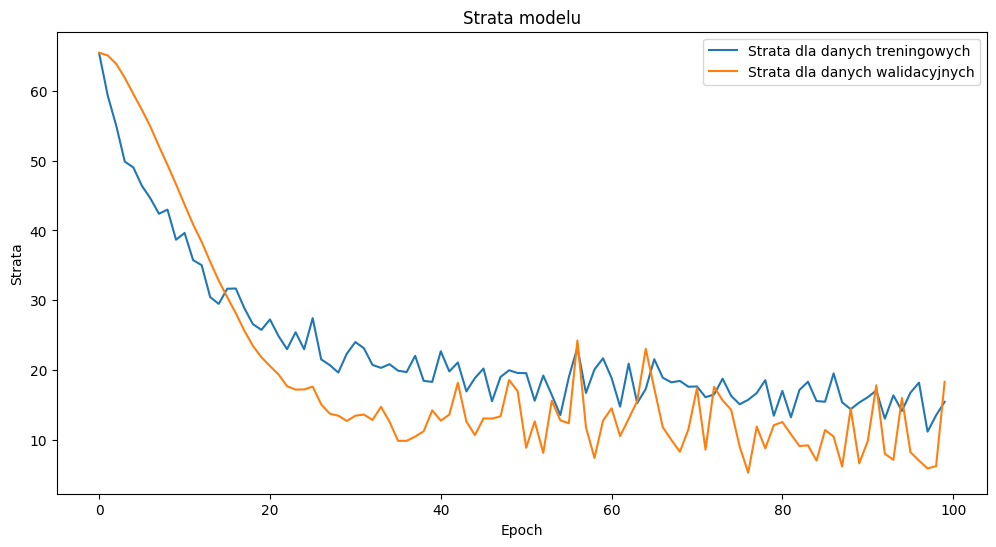

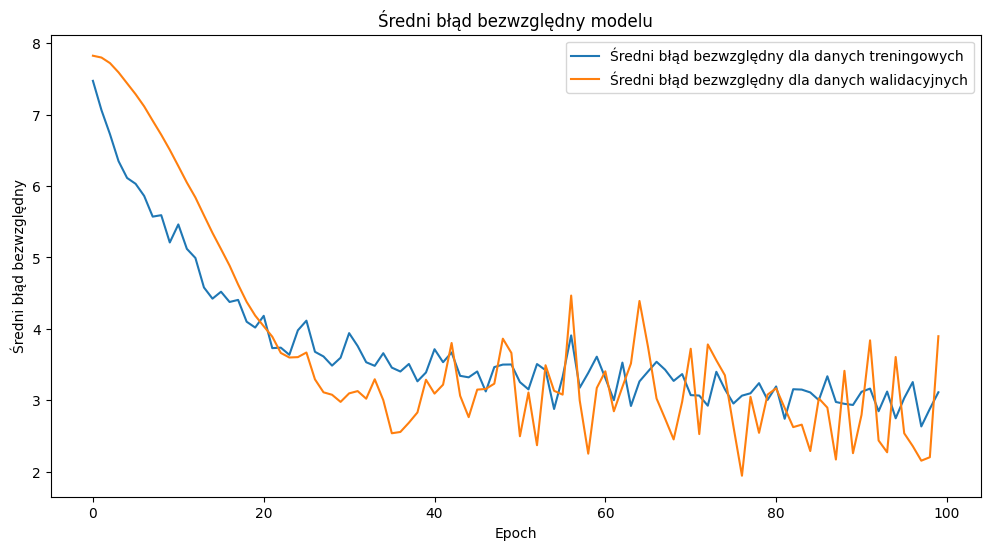

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pickle 
from keras.models import load_model
# Assuming `history` is the History object returned by model.fit()
# and `x_test_lstm`, `y_test` are the test datasets
with open('trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)
model = load_model("model.h5")
model.load_weights('model.weights.h5')

import os
if not os.path.isdir("plots_training"):
    os.makedirs('plots_training')

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Strata dla danych treningowych')
plt.plot(history['val_loss'], label='Strata dla danych walidacyjnych')
plt.title('Strata modelu')
plt.xlabel('Epoch')
plt.ylabel('Strata')
plt.legend(loc='upper right')
plt.savefig("plots_training/Strata dla danych treningowych")
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history['mae'], label='Średni błąd bezwzględny dla danych treningowych')
plt.plot(history['val_mae'], label='Średni błąd bezwzględny dla danych walidacyjnych')
plt.title('Średni błąd bezwzględny modelu')
plt.xlabel('Epoch')
plt.ylabel('Średni błąd bezwzględny')
plt.legend(loc='upper right')
plt.savefig("plots_training/Średni błąd bezwzględny dla danych treningowych")
plt.show()

